<a href="https://colab.research.google.com/github/JuWanMaeng/papaer-review/blob/main/DenseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow import keras
from keras.layers import Input,Flatten,Dense,BatchNormalization,Conv2D,AvgPool2D,MaxPool2D,Concatenate,GlobalAveragePooling2D
from keras.models import Sequential,Model
from keras.activations import relu as ReLU
from sklearn.model_selection import train_test_split
import tensorflow as tf

import numpy
import matplotlib.pyplot as plt


In [ ]:
(x_train,y_train),(x_test,y_test)=keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


In [ ]:
CLASS_NACLASS_NAMES= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=0.1)

In [ ]:
class DenseUnit(Sequential):
  def __init__(self,filter_out):
    super().__init__()

    # BN -> ReLU => Conv(1x1) ->BN -> ReLU -> Conv(3x3)

    self.bn=BatchNormalization()
    self.conv1=Conv2D(filter_out*4,(1,1),padding='same',kernel_initializer='he_noraml',kernel_regularizer=l2(1e-4))
    self.conv2=Conv2D(filter_out,(3,3),padding='same',kernel_initializer='he_normal')
    self.concat=Concatenate()
    

  def call(self,x):
    
    z=self.bn(x)
    z=ReLU(z)
    z-self.conv1(z)
    z=self.bn(axis=1)(z)
    z=ReLU(z)
    z=self.conv2(z)
    return self.concat([x,z])


In [ ]:
class DenseBlock(Model):
  def __init__(self,num_unit,growth_rate):
    super().__init__()
    self.sequence=list()
    self.concat=Concatenate()
    for idx in range(num_unit):
      self.sequence.append(DenseUnit(growth_rate))

  def call(self,x):
    for unit in self.sequence:
      x=unit(x)

    return x

In [ ]:
class TransitionLayer(Model):
  def __init__(self,filters):
    super().__init__()
    self.conv=Conv2D(filters,(1,1),padding='same')
    self.pool=MaxPool2D(2)

  def call(self,x):
  # 여기서는 BN이 없어서 training을 안써도 된다고 한다.

    x=self.conv(x)
    x=self.pool(x)

    return x

In [ ]:
class DenseNet(Sequential):
  def __init__(self):
    super().__init__()

    self.add(Conv2D(12,(7,7),strides=1,padding='same',input_shape=(32,32,3)))

    self.add(DenseBlock(6,12))
    self.add(TransitionLayer(12))
    self.add(DenseBlock(12,12))
    self.add(TransitionLayer(12))
    self.add(DenseBlock(24,12))
    

    self.add(AvgPool2D((8,8)))
    self.add(Flatten())
    self.add(Dense(128,activation='relu'))
    self.add(Dense(10,activation='softmax'))

    self.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics='accuracy')


In [ ]:
model=DenseNet()
model.summary()

Model: "dense_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 12)        1776      
_________________________________________________________________
dense_block (DenseBlock)     (None, 32, 32, 84)        0         
_________________________________________________________________
transition_layer (Transition (None, 16, 16, 12)        1020      
_________________________________________________________________
dense_block_1 (DenseBlock)   (None, 16, 16, 156)       0         
_________________________________________________________________
transition_layer_1 (Transiti (None, 8, 8, 12)          1884      
_________________________________________________________________
dense_block_2 (DenseBlock)   (None, 8, 8, 300)         0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 1, 1, 300)         0 

In [ ]:
callbacks=keras.callbacks.EarlyStopping(patience=20)
history=model.fit(x_test,y_test,batch_size=64,epochs=100,validation_data=(x_val,y_val),callbacks=callbacks)

Epoch 1/100
157/157 [==============================] - 44s 58ms/step - loss: 2.5632 - accuracy: 0.1897 - val_loss: 1.9695 - val_accuracy: 0.2550
Epoch 2/100
157/157 [==============================] - 3s 22ms/step - loss: 1.7985 - accuracy: 0.3273 - val_loss: 1.7774 - val_accuracy: 0.3396
Epoch 3/100
157/157 [==============================] - 3s 22ms/step - loss: 1.7019 - accuracy: 0.3696 - val_loss: 2.0156 - val_accuracy: 0.2688
Epoch 4/100
157/157 [==============================] - 3s 22ms/step - loss: 1.6213 - accuracy: 0.3999 - val_loss: 1.7856 - val_accuracy: 0.3568
Epoch 5/100
157/157 [==============================] - 3s 22ms/step - loss: 1.5734 - accuracy: 0.4214 - val_loss: 3.2400 - val_accuracy: 0.1788
Epoch 6/100
157/157 [==============================] - 3s 21ms/step - loss: 1.5490 - accuracy: 0.4207 - val_loss: 1.6812 - val_accuracy: 0.3780
Epoch 7/100
157/157 [==============================] - 3s 21ms/step - loss: 1.4841 - accuracy: 0.4524 - val_loss: 1.5415 - val_accuracy

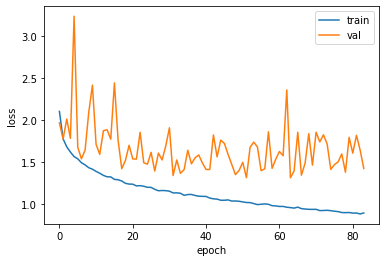

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

In [ ]:
model.evaluate(x_test,y_test)

313/313 [==============================] - 3s 7ms/step - loss: 1.0036 - accuracy: 0.6395


[1.0036276578903198, 0.6395000219345093]